# Homework on two-way fixed effects

By Clara Kyung and Rebecca Wu test* 

*We thank Edward Jee, Feng Lin, and Xianglong Kong for helpful discussion. All errors are our own. 

*29 September, 2021*

The goal of the following homework is to develop our understanding of two-way fixed effect models. 

Related papers:
 - the original paper by [Abowd, Kramarz, and Margolis](https://onlinelibrary.wiley.com/doi/abs/10.1111/1468-0262.00020).
 - [Andrews et al paper](https://www.jstor.org/stable/30135090)
 

## Preparing the environment

In [208]:
using Pkg
Pkg.activate(".") # Create new environment in this folder

Pkg.add(["Distributions","StatsBase"])
Pkg.add(["DataFrames","DataFramesMeta","Chain"])
Pkg.add(["Plots","Random","Missings"])
Pkg.add(["ShiftedArrays","CategoricalArrays"])
Pkg.add("Optim")
Pkg.add(["SparseArrays","LightGraphs"])
Pkg.add("GLM")


# past the first time, you only need to instanciate the current folder
Pkg.instantiate() # Updates packages given .toml file

  Activating environment at `~/Dropbox/PhD 2020/2nd Year/Fall/ECON 34430/PSET/PSET1/Project.toml`
   Resolving package versions...
  No Changes to `~/Dropbox/PhD 2020/2nd Year/Fall/ECON 34430/PSET/PSET1/Project.toml`
  No Changes to `~/Dropbox/PhD 2020/2nd Year/Fall/ECON 34430/PSET/PSET1/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Dropbox/PhD 2020/2nd Year/Fall/ECON 34430/PSET/PSET1/Project.toml`
  No Changes to `~/Dropbox/PhD 2020/2nd Year/Fall/ECON 34430/PSET/PSET1/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Dropbox/PhD 2020/2nd Year/Fall/ECON 34430/PSET/PSET1/Project.toml`
  No Changes to `~/Dropbox/PhD 2020/2nd Year/Fall/ECON 34430/PSET/PSET1/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Dropbox/PhD 2020/2nd Year/Fall/ECON 34430/PSET/PSET1/Project.toml`
  No Changes to `~/Dropbox/PhD 2020/2nd Year/Fall/ECON 34430/PSET/PSET1/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Dropbox/PhD 2020/2nd Year/

We then list our imports

In [209]:
using Distributions
using LinearAlgebra
using StatsBase
using DataFrames
using Plots
using CategoricalArrays
using ShiftedArrays
using Random
using Chain
using DataFramesMeta
using SparseArrays
using LightGraphs
using GLM

global_seed = 1234
Random.seed!(global_seed)

MersenneTwister(1234)

## Constructing Employer-Employee matched data

### Create a mobility matrix

One central piece is to have a network of workers and firms over time. We start by simulating such an object. The rest of the homework will focus on adding wages to this model. As we know from the lectures, a central issue of the network will be the number of movers.

We are going to model the mobility between workers and firms. Given a transition matrix we can solve for a stationary distribution, and then construct our panel from there.

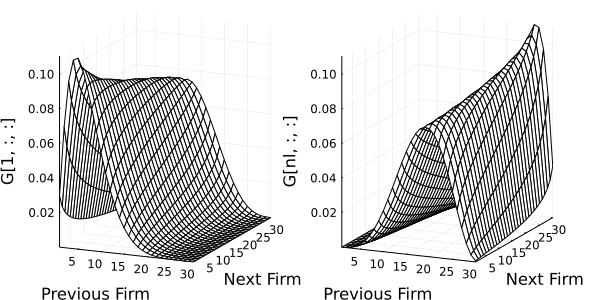

In [210]:
α_sd = 1
ψ_sd = 1

# approximate each distribution with some points of support
nk = 30  # types of firms 
nl = 10  # types of workers
ψ = quantile.(Normal(), (1:nk) / (nk + 1)) * α_sd # firm effect
α = quantile.(Normal(), (1:nl) / (nl + 1)) * ψ_sd # worker effect

# Let's assume moving probability is fixed
λ = 0.1

csort = 0.5 # Sorting effect
cnetw = 0.2 # Network effect
csig  = 0.5 # Cross-sectional standard deviation

# Let's create type-specific transition matrices
# We are going to use joint normals centered on different values
G = zeros(nl, nk, nk)
for l in 1:nl, k in 1:nk
    G[l, k, :] = pdf( Normal(0, csig), ψ .- cnetw * ψ[k] .- csort * α[l])
    G[l, k, :] = G[l, k, :] ./ sum(G[l, k, :])
end

# We then solve for the stationary distribution over psis for each alpha value
# We apply a crude fixed point approach
H = ones(nl, nk) ./ nk
for l in 1:nl
    M = transpose(G[l, :, :])
    for i in 1:100
        H[l, :] = M * H[l, :]
    end
end

p1 = plot(G[1, :, :], xlabel="Previous Firm", ylabel="Next Firm", zlabel="G[1, :, :]", st=:wireframe)
p2 = plot(G[nl, :, :], xlabel="Previous Firm", ylabel="Next Firm", zlabel="G[nl, :, :]", st=:wireframe, right_margin = 10Plots.mm) # right_margin makes sure the figure isn't cut off on the right
plot(p1, p2, layout = (1, 2), size=[600,300])

And we can plot the joint distribution of matches

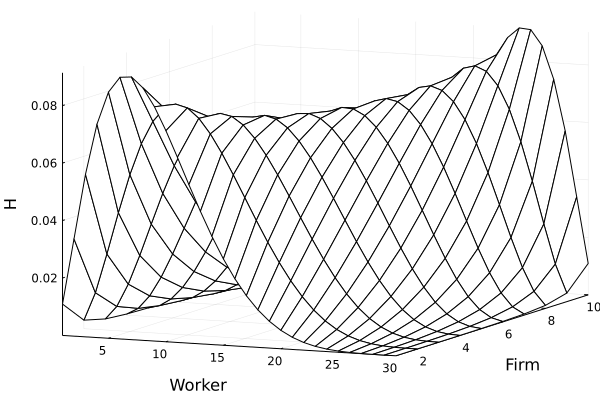

In [124]:
plot(H, xlabel="Worker", ylabel="Firm", zlabel="H", st=:wireframe) # should the x and y-axis labels be switched? 

<span style="color:green">Question 1</span>

 - Explain what the parameters `cnetw` and  `csort` do.


<span style="color:blue">Answer 1</span>

`cnetw` captures the firm network effect and `csort` captures the sorting effect between workers and firms. When we construct the transition matrix, we use joint normals centered on the transition effect net out sorting and network effects. 


### Simulate a panel

The next step is to simulate our network given our transition rules.

In [211]:
nt = 10
ni = 10000

# We simulate a balanced panel
ll = zeros(Int64, ni, nt) # Worker type
kk = zeros(Int64, ni, nt) # Firm type
spellcount = zeros(Int64, ni, nt) # Employment spell

for i in 1:ni
    
    # We draw the worker type
    l = rand(1:nl)
    ll[i,:] .= l
    
    # At time 1, we draw from H
    kk[i,1] = sample(1:nk, Weights(H[l, :]))
    
    for t in 2:nt
        if rand() < λ # move
            kk[i,t] = sample(1:nk, Weights(G[l, kk[i,t-1], :]))
            spellcount[i,t] = spellcount[i,t-1] + 1
        else  # stay 
            kk[i,t] = kk[i,t-1]
            spellcount[i,t] = spellcount[i,t-1]
        end
    end
    
end

### Attach firm ids to types

The final step is to assign identities to the firms. We are going to do this is a relatively simple way, by simply randomly assigning firm ids to spells.

In [213]:
firms_per_type = 15
jj = zeros(Int64, ni, nt) # Firm identifiers

draw_firm_from_type(k) = sample(1:firms_per_type) + (k - 1) * firms_per_type

for i in 1:ni
    
    # extract firm type
    k = kk[i,1]
    
    # We draw the firm (one of firms_per_type in given group)
    jj[i,1] = draw_firm_from_type(k)
    
    for t in 2:nt
        if spellcount[i,t] == spellcount[i,t-1]
            # We keep the firm the same
            jj[i,t] = jj[i,t-1]
        else
            # We draw a new firm
            k = kk[i,t]
            
            new_j = draw_firm_from_type(k)            
            # Make sure the new firm is actually new
            while new_j == jj[i,t-1]
                new_j = draw_firm_from_type(k)
            end
            
            jj[i,t] = new_j
        end
    end
end


# Make sure firm ids are contiguous
contiguous_ids = Dict( unique(jj) .=> 1:length(unique(jj))  )
jj .= getindex.(Ref(contiguous_ids),jj);

<span style="color:green">Question 2</span>

 - Explain the last 2 lines, in particular `.=>` and the use of `Ref`. 

<span style="color:blue">Answer 2</span>

Note that in the matrix jj, there are 445 unique elements (or firm ids). We want to make sure that firm ids are contiguous. The second to last line converts each unique firm id in matrix jj to a unique integer in the range of 1 to 445 and name the sequence "contiguous_ids". `.=>` serves the purpose of translating the former unique id to the latter contiguous one. The last line takes the matrix jj and translates each original id to the contiguous id. `Ref` works to get reference from the matching created in the second to last line.  

In [214]:
ii = repeat(1:ni,1,nt)
tt = repeat((1:nt)',ni,1)
df = DataFrame(i=ii[:], j=jj[:], l=ll[:], k=kk[:], α=α[ll[:]], ψ=ψ[kk[:]], t=tt[:], spell=spellcount[:]);

<span style="color:green">Question 3</span>

Use `Chain.jl` and `DataFramesMeta.jl` to computer:

 - mean firm size, in the crossection, expect something like 15.
 - mean number of movers per firm in total in our panel.


<span style="color:blue">Answer 3</span>

In [216]:
gdf1 = DataFrame(combine(groupby(df, [:j, :t]), nrow => :count))
mean_worker = round(mean(gdf1.count))
print("Mean firm size is around $mean_worker in each time period.")

Mean firm size is around 23.0 in each time period.

In [217]:
function avg_num_mover(df)
    avg_num_mover = @chain df begin
        groupby([:i, :j, :spell])
        combine(:t => mean)
        @transform!(:mover = :spell)
        transform(:mover => (mover -> ifelse.(mover .>= 1, 1, mover)) => :mover)
        groupby(:j)
        combine(:mover => sum)
        round(mean(_.mover_sum))
    end
    return avg_num_mover
end 

avg_mover = avg_num_mover(df)
print("Mean number of movers per firm is around $avg_mover. ")

Mean number of movers per firm is around 20.0. 

## Simulating AKM wages and create Event Study plot

We start with just AKM wages, which is log additive with some noise.

In [218]:
w_sigma = 0.2
df[!, :lw] = df.α + df.ψ + w_sigma * rand(Normal(), size(df)[1]);

<span style="color:green">Question 4</span>

Before we finish with the simulation code. Use this generated data to create the event study plot from [Card. Heining, and Kline](https://doi.org/10.1093/qje/qjt006):

1. Compute the mean wage within firm
2. Group firms into quartiles
3. Select workers around a move (2 periods pre, 2 periods post)
4. Compute wages before/after the move for each transition (from each quartile to each quartile)
5. Plot the lines associated with each transition

<span style="color:blue">Answer 4.1</span>

In [219]:
# Steps 1 & 2
quartile = @chain df begin
    groupby([:j])
    combine(:lw => mean)
    @transform!(:lw_quartile = levelcode.(cut(:lw_mean, 4))) 
    select!(Not([:lw_mean]))
end

wage_Panel =  @chain df begin
    
    innerjoin(_, quartile, on = [:j])
   
    # Step 3: Select workers around a move (2 periods pre, 2 periods post)
    groupby([:i]) 
    transform!(:j => lead => :j_lead) #, :j => lag => :j_lag)
    @transform!(:move_dum = (:j_lead .!= :j)) 
    transform(:move_dum => (x -> ifelse.(ismissing.(x), 0, x)) => :move_dum)
    
    groupby([:i])
    transform(:move_dum => sum)
    subset!(:move_dum_sum => ByRow(x -> x .== 1)) # keep only one-time movers 

    @transform!(:move_time = (:j_lead .!= :j).*:t) 
    transform(:move_time => (x -> ifelse.(ismissing.(x), 0, x)) => :move_time)

    groupby([:i])
    transform(:move_time => maximum => :move_time)
    @transform!(:time_diff = :t .- :move_time)
    @subset!(:move_time.> 1, :move_time .< 9, :time_diff .>= -1, :time_diff .<= 2) # final dataset containing suitable one-time movers

    # Step 4: Compute wages before/after the move for each transition (from each quartile to each quartile)
    
    # create pre-post dummy
    @transform!(:pre = 0, :post = 0)
    transform(:time_diff => (y -> ifelse.(y .< 1, 1, 0)) => :pre, :time_diff => (y -> ifelse.(y .> 0, 1, 0)) => :post)
    
    # generate pre- & post-quartile
    @transform!(:pre_quartile = :lw_quartile .* :pre, :post_quartile = :lw_quartile .* :post)
    groupby([:i])
    transform(:pre_quartile => maximum => :pre_quartile, :post_quartile => maximum => :post_quartile)
    
    # compute mean wage before and after the move
    groupby([:time_diff, :pre_quartile, :post_quartile])
    transform(:lw => mean)
    rename!(:lw_mean => :wage_transit)
    select!(:pre, :post, :wage_transit, :pre_quartile, :post_quartile, :time_diff)
    unique()
end


,pre,post,wage_transit,pre_quartile,post_quartile,time_diff
,Int64,Int64,Float64,Int64,Int64,Int64
1,1,0,-1.63171,1,2,-1
2,1,0,-1.97801,1,1,-1
3,1,0,1.65897,4,3,-1
4,1,0,-0.682314,2,2,-1
5,1,0,-0.355485,2,3,-1
6,1,0,-1.1898,1,3,-1
7,1,0,0.287196,3,2,-1
8,1,0,1.94416,4,4,-1
9,1,0,0.681217,3,3,-1


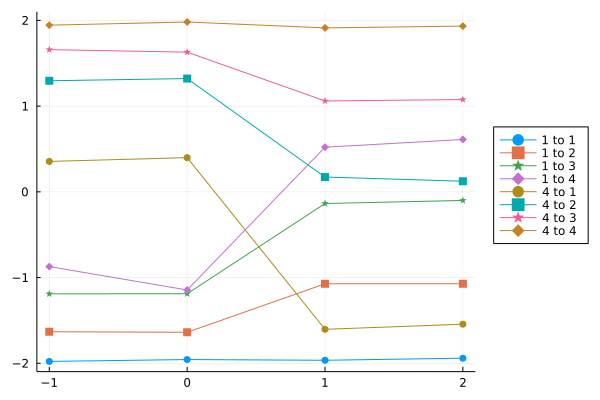

In [220]:
# Step 5: Plot the lines associated with each transition

p = plot()
for pre in (1, 4)
    for (post, marker) in zip(1:4, [:circle, :rect, :star5, :diamond])
        wage_Panel_temp = @subset(wage_Panel, :pre_quartile.==pre, :post_quartile.==post)
        plot!(wage_Panel_temp.time_diff, wage_Panel_temp.wage_transit, 
            markershape = marker, 
            markerstrokewidth = 0,
            label = "$pre to $post",
            legend = :outerright)
    end
end
display(p)

## Calibrating the parameters

<span style="color:green">Question 5</span>

 - Pick the parameters `psi_sd`, `alpha_sd`, `csort`, `csig`, and `w_sigma` to roughly match the decomposition in the Card-Heining-Kline paper (note that they often report numbers in standard deviations, not in variances).

<span style="color:Blue">Anwser 5</span>

In [221]:
function sim_panel(param; get_df = 0, K = 30, L = 10, mob = 0.1, T = 10, I = 10000)
    
    α_sd = param[1]
    ψ_sd = param[2]
    csort = param[3]
    csig = param[4]
    w_sigma = param[5]

    # approximate each distribution with some points of support
    nk = K
    nl = L
    ψ = quantile.(Normal(), (1:nk) / (nk + 1)) * α_sd
    α = quantile.(Normal(), (1:nl) / (nl + 1)) * ψ_sd

    # Let's assume moving probability is fixed
    λ = mob

    # csort = 0.5 # Sorting effect
    cnetw = 0.2 # Network effect
    # csig  = 0.5 # Cross-sectional standard deviation

    # Let's create type-specific transition matrices
    # We are going to use joint normals centered on different values
    G = zeros(nl, nk, nk)
    for l in 1:nl, k in 1:nk
        G[l, k, :] = pdf( Normal(0, csig), ψ .- cnetw * ψ[k] .- csort * α[l])
        G[l, k, :] = G[l, k, :] ./ sum(G[l, k, :])
    end

    # We then solve for the stationary distribution over psis for each alpha value
    # We apply a crude fixed point approach
    H = ones(nl, nk) ./ nk
    for l in 1:nl
        M = transpose(G[l, :, :])
        for i in 1:100
            H[l, :] = M * H[l, :]
        end
    end

    nt = T
    ni = I

    # We simulate a balanced panel
    ll = zeros(Int64, ni, nt) # Worker type
    kk = zeros(Int64, ni, nt) # Firm type
    spellcount = zeros(Int64, ni, nt) # Employment spell, count the number of moves

    for i in 1:ni

        # We draw the worker type
        l = rand(1:nl)
        ll[i,:] .= l

        # At time 1, we draw from H
        kk[i,1] = sample(1:nk, Weights(H[l, :]))

        for t in 2:nt
            if rand() < λ
                kk[i,t] = sample(1:nk, Weights(G[l, kk[i,t-1], :]))
                spellcount[i,t] = spellcount[i,t-1] + 1
            else
                kk[i,t] = kk[i,t-1]
                spellcount[i,t] = spellcount[i,t-1]
            end
        end

    end
    
    
    firms_per_type = 15
    jj = zeros(Int64, ni, nt) # Firm identifiers

    draw_firm_from_type(k) = sample(1:firms_per_type) + (k - 1) * firms_per_type

    for i in 1:ni

        # extract firm type
        k = kk[i,1]

        # We draw the firm (one of firms_per_type in given group)
        jj[i,1] = draw_firm_from_type(k)

        for t in 2:nt
            if spellcount[i,t] == spellcount[i,t-1]
                # We keep the firm the same
                jj[i,t] = jj[i,t-1]
            else
                # We draw a new firm
                k = kk[i,t]

                new_j = draw_firm_from_type(k)            
                # Make sure the new firm is actually new
                while new_j == jj[i,t-1]
                    new_j = draw_firm_from_type(k)
                end

                jj[i,t] = new_j
            end
        end
    end

    # Make sure firm ids are contiguous
    contiguous_ids = Dict( unique(jj) .=> 1:length(unique(jj))  )
    jj .= getindex.(Ref(contiguous_ids),jj);
    
    
    ii = repeat(1:ni,1,nt)
    tt = repeat((1:nt)',ni,1)
    df = DataFrame(i=ii[:], j=jj[:], l=ll[:], k=kk[:], α=α[ll[:]], ψ=ψ[kk[:]], t=tt[:], spell=spellcount[:]);
    
    # w_sigma = 0.2
    df[!, :lw] = df.α + df.ψ + w_sigma * rand(Normal(), size(df)[1]);
    
    # Compute simulated moments
    lw_std_sim = std(df.lw)
    α_sd_sim = std(df.α)
    ψ_sd_sim = std(df.ψ)
    αψ_corr_sim = cor(df.α, df.ψ)
    ϵ_sd_sim = std(df.lw - (df.α + df.ψ))
    
    if get_df == 1 
        return(df)
    else 
        return (lw_std_sim, α_sd_sim, ψ_sd_sim, αψ_corr_sim, ϵ_sd_sim)
    end
    
end

sim_panel (generic function with 1 method)

In [222]:
using Optim
Random.seed!(global_seed)
moment_data = [0.499, 0.357, 0.230, 0.249, 0.122] # Numbers from Table III, column (4)
param_init = [0.4, 0.4, 0.4, 0.4, 0.4]

results = optimize(x -> sum((sim_panel(x) .- moment_data).^2), param_init, g_tol = 1e-6, show_trace = false)

param_sol = results.minimizer
println("Parameter vector is given by $param_sol")
moment_sim = sim_panel(param_sol)
println("Computed variances under the calibrated parameters are $moment_sim")

Parameter vector is given by [0.27753786553402343, 0.4576301135904206, 0.6447623485274637, 0.46545637112192945, 0.12252193229087875]
Computed variances under the calibrated parameters are (0.49048263233837175, 0.3615737992066635, 0.23039602894136565, 0.250121967594491, 0.12247027960749823)


## Estimating two-way fixed effects

This requires first extracting the large set of firms connected by movers, and then estimating the linear problem with many dummies.

### Extracting the connected set

Because we are not going to deal with extremely large data-sets, we can use off-the-shelf algorithms to extract the connected set. Use the function `connected_components` from the package `LightGraphs` to extract the connected set from our data. To do so you will need to first construct an adjacency matrix between the firms. 

<span style="color:green">Question 6</span>

 - Extract the connected set and drop firms not in the set (I expect that all firms will be in the set).

In [223]:
# use simulated data 
Random.seed!(global_seed)
sim_df = sim_panel(param_sol; get_df = 1) 
describe(sim_df.j)

adj_df = @chain sim_df begin
    groupby([:i]) 
    transform!(:j => lead => :j_lead) 
    transform!([:j_lead, :j] => ByRow(coalesce) => :j_lead)
    @transform!(:move_dum = (:j_lead .!= :j) .* 1) 
    transform(:move_dum => (x -> ifelse.(ismissing.(x), 0, x)) => :move_dum)
    
    # keep all movers 
    @subset(:move_dum .== 1) 
    sparse(_.j, _.j_lead, ones(size(_)[1]))
end 

adj_matrix = ((adj_df + adj_df') .> 0) .* 1

# extract connected set 
connected_components(SimpleGraph(adj_matrix)) 

Summary Stats:
Length:         100000
Missing Count:  0
Mean:           220.660040
Minimum:        1.000000
1st Quartile:   111.000000
Median:         219.000000
3rd Quartile:   329.000000
Maximum:        450.000000
Type:           Int64


1-element Vector{Vector{Int64}}:
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  441, 442, 443, 444, 445, 446, 447, 448, 449, 450]

### Estimating worker and firm FEs

This part of the problem set is for you to implement the AKM estimator. As discussed in class, this can be done simply by updating, in turn, the worker FE and the firm FE.

Start by appending 2 new columns `alpha_hat` and `psi_hat` to your data. Then loop over the following:

1. Update `alpha_hat` by taking the mean within `i` net of firm FE
2. Update `psi_hat` by taking the mean within `fid` net of worker FE

<span style="color:green">Question 7</span>

 - Run the previous steps in a loop, and at each step evaluate how much the total mean square error has changed. Check that is goes down with every step. Stop when the MSE decreases by less than 1e-9.


Note that you can increase speed by focusing on movers only first.



In [224]:
function estimation(sim_df::DataFrame, α_hat_init, ψ_hat_init; tol = 1e-9)
    sim_df[!, :alpha_hat] .= α_hat_init
    sim_df[!, :psi_hat] .= ψ_hat_init
    # tol = 1e-9;
    mse = ones(1000);
    sim_df_iter = sim_df
    
    for i = 2:1000
        sim_df_iter = @chain sim_df_iter begin 

            @transform!(:alpha_temp = :lw - :psi_hat)
            groupby(:i)
            transform!(:alpha_temp => mean => :alpha_hat) 

            @transform!(:psi_temp = :lw - :alpha_hat)
            groupby(:j)
            transform!(:psi_temp => mean => :psi_hat) 
        end 
    
        mse[i] = mean((sim_df_iter.lw - sim_df_iter.alpha_hat - sim_df_iter.psi_hat).^2)
        if ((mse[i-1] - mse[i]) < tol)
            break
        end
    end 
    return sim_df_iter
end

α_hat_init = 0.01
ψ_hat_init = 0.01

sim_df_iter = estimation(sim_df, α_hat_init, ψ_hat_init)
sim_df_iter[!, [:i, :j, :t, :α, :ψ, :alpha_hat, :psi_hat]]

describe(sim_df_iter)

,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Int64,DataType
1,i,5000.5,1,5000.5,10000,0,Int64
2,j,220.66,1,219.0,450,0,Int64
3,l,5.5275,1,6.0,10,0,Int64
4,k,15.5033,1,15.0,30,0,Int64
5,α,0.0033019,-0.611018,0.0522546,0.611018,0,Float64
6,ψ,-1.47731e-5,-0.513055,-0.0112238,0.513055,0,Float64
7,t,5.5,1,5.5,10,0,Int64
8,spell,0.45603,0,0.0,5,0,Int64
9,lw,0.00343628,-1.45486,0.000119593,1.58685,0,Float64


Comment: we wonder why the mean of psi_hat is the same as the initial guess we set and whether it matters for the estimation. 

## Limited mobility bias

We now have everything we need to look at the impact of limited mobility bias. Compute the following:

1. Compute the estimated variance of firm FE
2. Do it for varying levels of mobility λ. For each the number of movers, collect the actual variance and the estimated variance. Run it for different panel lengths: 5, 6, 8, 10, 15.

<span style="color:green">Question 8</span>

 - Report this in a plot. This should look like the [Andrews et al.](https://www.sciencedirect.com/science/article/pii/S0165176512004272) plot.

In [225]:
mob_val = [0.02, 0.04, 0.06, 0.08, 0.1]
time_val = [5, 6, 8, 10, 15]
output = zeros(length(time_val), 4, length(mob_val))

for i in 1:length(mob_val)[1] 
   
    for j in 1:length(time_val)[1] 
        
        Random.seed!(global_seed) 
        m = mob_val[i]
        t = time_val[j]
        
        df_mb = sim_panel(param_sol; get_df = 1, K = 30, L = 10, mob = m, T = t, I = 10000)
        df_mb = estimation(df_mb)
        
        df_mb_firmFE = combine(groupby(df_mb, :j), :ψ => mean => :actual_ψ,  :psi_hat => mean => :estimated_ψ) 
        
        output[i, 1, j] = cor(df_mb.alpha_hat, df_mb.psi_hat)
        output[i, 2, j] = avg_num_mover(df_mb)
        output[i, 3, j] = var(df_mb_firmFE.actual_ψ)
        output[i, 4, j] = var(df_mb_firmFE.estimated_ψ)
        
    end
end

0.9865714037892236
0.00016661493956798314
0.00014230644564898302
0.00012270114900619043
0.00010667741490365777
9.342011882780901e-5
8.232991623026431e-5
7.296060403082227e-5
6.49756525125094e-5
5.8117861697588175e-5
5.2188036595773174e-5
4.702988673301739e-5
4.2519242549150446e-5
3.855628267621092e-5
3.5059874647330735e-5
3.1963409751010335e-5
2.9211702653955327e-5
2.6758656473014827e-5
2.4565483362484417e-5
2.259933236703829e-5
2.083221905447262e-5
1.9240181245975055e-5
1.7802606054464348e-5
1.650168818467801e-5
1.5321989927539678e-5
1.4250080788740654e-5
1.3274240116012762e-5
1.238421004537936e-5
1.1570988998670095e-5
1.0826658130383762e-5
1.0144234748566197e-5
9.517547968884363e-6
8.94113280759494e-6
8.410139651825188e-6
7.920256618412086e-6
7.467642764290294e-6
7.048870471008592e-6
6.660875613923728e-6
6.3009143599114525e-6
5.966525626205366e-6
5.655498388615343e-6
5.365843154272326e-6
5.095767020129802e-6
4.843651825563178e-6
4.608034981114922e-6
4.38759261630825e-6
4.181124741233

1.0203655319979132e-8
1.0100831436890556e-8
9.999180079420245e-9
9.898686004553015e-9
9.799334163562712e-9
9.70110976619698e-9
9.603998213023046e-9
9.507985145734699e-9
9.41305640204948e-9
9.31919804346426e-9
9.226396324030217e-9
9.134637707700066e-9
9.043908852715554e-9
8.954196620281074e-9
8.865488060685878e-9
8.777770408099905e-9
8.69103109271685e-9
8.605257714733305e-9
8.520438061696e-9
8.436560105032354e-9
8.353611975764341e-9
8.271581983590459e-9
8.190458608212103e-9
8.110230490659953e-9
8.030886431559248e-9
7.952415401538127e-9
7.874806523880395e-9
7.798049064117185e-9
7.722132471660315e-9
7.647046303474458e-9
7.57278030560915e-9
7.499324331666779e-9
7.426668415660975e-9
7.354802692219331e-9
7.2837174711765096e-9
7.213403171654753e-9
7.143850351554182e-9
7.075049719695858e-9
7.006992083780084e-9
6.939668411101718e-9
6.873069759161243e-9
6.807187341584253e-9
6.742012474345027e-9
6.677536594848488e-9
6.613751270603818e-9
6.550648164529993e-9
6.488219076589141e-9
6.426455896949013e

2.8823291256356576e-7
2.811211684342063e-7
2.742318609885025e-7
2.6755653514433375e-7
2.6108711322601896e-7
2.5481587562735386e-7
2.48735442631709e-7
2.4283875725561455e-7
2.371190690551167e-7
2.315699188636805e-7
2.2618512438357663e-7
2.2095876658738411e-7
2.1588517684113795e-7
2.1095892478728562e-7
2.0617480683132738e-7
2.0152783531540708e-7
1.970132282175241e-7
1.9262639944749027e-7
1.8836294962860933e-7
1.842186573858956e-7
1.8018947111307637e-7
1.7627150108480427e-7
1.7246101210316445e-7
1.6875441642347222e-7
1.651482670807919e-7
1.6163925156513492e-7
1.5822418581237785e-7
1.5490000846406227e-7
1.5166377548801735e-7
1.485126549724547e-7
1.4544392227221203e-7
1.4245495533193875e-7
1.3954323024173432e-7
1.3670631705126057e-7
1.339418757347749e-7
1.3124765239382052e-7
1.2862147559696002e-7
1.260612529519617e-7
1.2356496776645687e-7
1.2113067594451965e-7
1.1875650296304385e-7
1.1644064102159235e-7
1.1418134632928956e-7
1.1197693648538898e-7
1.0982578801943532e-7
1.0772633400601972e-7


1.4458720002524794e-9
1.4317802603247554e-9
1.417837581715875e-9
1.4040422557232146e-9
1.3903925927261085e-9
1.3768869117775084e-9
1.3635235752984531e-9
1.3503009439752578e-9
1.337217416658154e-9
1.324271397401544e-9
1.3114613180154056e-9
1.2987856380652918e-9
1.2862428101778622e-9
1.2738313355520337e-9
1.2615497205908932e-9
1.2493964838405924e-9
1.2373701750723054e-9
1.2254693562002705e-9
1.213692603016514e-9
1.2020385121297439e-9
1.1905057009653497e-9
1.1790928025612324e-9
1.1677984620983572e-9
1.1566213421049243e-9
1.1455601259258152e-9
1.1346135125184231e-9
1.1237802095137583e-9
1.113058952298407e-9
1.1024484831978487e-9
1.0919475514764576e-9
1.0815549515014178e-9
1.0712694533537848e-9
1.061089873952148e-9
1.0510150232762028e-9
1.0410437425306673e-9
1.0311748711855362e-9
1.0214072729969326e-9
1.011739827333491e-9
1.002171417033293e-9
9.927009388122077e-10
0.9848079881563514
0.00028031733760278815
0.00023696436699990366
0.00020179070572911087
0.00017292002967605503
0.000148997915396

1.1042773050140564e-9
1.0870864521062007e-9
1.070217836227072e-9
1.0536645254216603e-9
1.0374197681461972e-9
1.0214769689820269e-9
1.0058296921050536e-9
9.90471638734336e-10
0.9838639889153991
0.0003885293534720974
0.0003214640744092414
0.00026795397868264494
0.00022487361532392246
0.0001899094788218314
0.00016132528050049298
0.00013780141181893475
0.0001183234944950682
0.00010210382727712797
8.852518448884683e-5
7.710002164591952e-5
6.74404582492634e-5
5.92359102200464e-5
5.2236229833671835e-5
4.6238864893455994e-5
4.1078988289880436e-5
3.6621848336287205e-5
3.2756796898760626e-5
2.9392597019334624e-5
2.6453714443899073e-5
2.387737136145228e-5
2.1611194497065528e-5
1.961132938373654e-5
1.7840922202222442e-5
1.626889281632765e-5
1.4868939503621947e-5
1.3618728780886297e-5
1.249923365262244e-5
1.1494191299196016e-5
1.058965720687928e-5
9.773637423986237e-6
9.035784305638783e-6
8.367144011004954e-6
7.759946313551369e-6
7.207429108849542e-6
6.703691458496627e-6
6.2435701702057145e-6
5.822

2.7535749941298704e-7
2.543151325570814e-7
2.3499021004069753e-7
2.17232376175866e-7
2.0090544921268216e-7
1.8588597891673608e-7
1.7206196270026786e-7
1.593317015251977e-7
1.4760277921785359e-7
1.367911507451497e-7
1.268203269899626e-7
1.1762064502582326e-7
1.0912861413657493e-7
1.0128632929422288e-7
9.404094445351896e-8
8.734419919449732e-8
8.115199286520824e-8
7.542400118874804e-8
7.012333063695364e-8
6.521620676130935e-8
6.067169282426843e-8
5.6461435457566544e-8
5.255943487034176e-8
4.894183672742025e-8
4.558674373232596e-8
4.247404492528639e-8
3.958526071171087e-8
3.6903402372140404e-8
3.4412844324149816e-8
3.2099208130062507e-8
2.994925695463946e-8
2.7950799504766755e-8
2.6092602583779878e-8
2.4364311417349183e-8
2.275637698417876e-8
2.1259989759978004e-8
1.9867019139183095e-8
1.8569958295036604e-8
1.736187358811203e-8
1.623635842787352e-8
1.518749104777173e-8
1.4209795838257544e-8
1.3298207944545393e-8
1.2448040830753682e-8
1.165495656062221e-8
1.0914938505107719e-8
1.0224266369

2.574325837570446e-9
2.536308205125515e-9
2.4988816519494472e-9
2.462036121850253e-9
2.425761768537482e-9
2.3900489400097147e-9
2.354888147329537e-9
2.3202701183999697e-9
2.2861857355144233e-9
2.252626063112273e-9
2.2195823391052416e-9
2.1870459662037822e-9
2.1550085032434607e-9
2.1234616825321906e-9
2.09239737342104e-9
2.0618076222028714e-9
2.0316845983359144e-9
2.0020206326076817e-9
1.9728081928488406e-9
1.9440398891373833e-9
1.915708461655563e-9
1.8878067963024048e-9
1.860327889999236e-9
1.8332648871188795e-9
1.8066110447911843e-9
1.780359743311366e-9
1.7545044878747307e-9
1.729038899903057e-9
1.7039567049015325e-9
1.6792517567448817e-9
1.654918002982897e-9
1.6309495178001843e-9
1.607340463852247e-9
1.5840851061432737e-9
1.5611778259039255e-9
1.538613096305208e-9
1.5163854755195771e-9
1.494489636211238e-9
1.472920334311123e-9
1.4516724159557848e-9
1.43074081401795e-9
1.4101205550454132e-9
1.3898067609957598e-9
1.3697946058682797e-9
1.3500793781540121e-9
1.3306564409371058e-9
1.31152

4.464305008479441e-8
4.132411094738553e-8
3.826341707889591e-8
3.54398810489126e-8
3.2834227217323764e-8
3.04288275444764e-8
2.8207553062417623e-8
2.6155639591685098e-8
2.4259566055659376e-8
2.2506944377664873e-8
2.0886419562632375e-8
1.9387579090757168e-8
1.8000870766199384e-8
1.6717527993870274e-8
1.5529501962152636e-8
1.4429399976950696e-8
1.341042933124259e-8
1.2466346279924045e-8
1.1591409521463647e-8
1.0780337834220832e-8
1.002827148405272e-8
9.3307370059581e-9
8.68361507005977e-9
8.083111171716673e-9
7.52572882137259e-9
7.0082451213843155e-9
6.527688344720728e-9
6.081317538084163e-9
5.666603783427426e-9
5.281213064090018e-9
4.922990608918765e-9
4.589946546104673e-9
4.280242688059488e-9
3.992180530598688e-9
3.724190164589025e-9
3.4748201382245325e-9
3.242728129418393e-9
3.0266724265759493e-9
2.8255040477459525e-9
2.638159564069542e-9
2.463654431503204e-9
2.3010769574505208e-9
2.1495826247469596e-9
2.008389008920086e-9
1.8767709886180484e-9
1.7540564070661624e-9
1.6396220388348315

1.5292084357149821e-6
1.353282341227599e-6
1.1992429805127852e-6
1.064150032176192e-6
9.454890176410768e-7
8.411049293478856e-7
7.491469693789166e-7
6.680224061018231e-7
5.963579377057937e-7
5.329672557539272e-7
4.7682374437404973e-7
4.2703744600192106e-7
3.828355811235501e-7
3.4354603659948746e-7
3.0858333968653007e-7
2.774367187305393e-7
2.4965991948962263e-7
2.2486250220860038e-7
2.027023899876801e-7
1.8287947717993136e-7
1.6513013723420955e-7
1.4922249559623513e-7
1.349523542741593e-7
1.2213967275596926e-7
1.1062552457592745e-7
1.0026946137449422e-7
9.094722652758236e-8
8.254876921950927e-8
7.497651707648323e-8
6.814387177624115e-8
6.197389702290723e-8
5.6398172978977534e-8
5.135579467935303e-8
4.679249536627961e-8
4.2659878209810875e-8
3.891474225671543e-8
3.551849039017119e-8
3.2436608767005826e-8
2.963820854018362e-8
2.7095622112324746e-8
2.478404694146452e-8
2.2681231053034434e-8
2.0767195100732105e-8
1.9023986436508822e-8
1.7435461375017725e-8
1.5987092158789573e-8
1.466579574

4.962728651580414e-5
3.8905799681585376e-5
3.0676651054451984e-5
2.4317021069003575e-5
1.9370769648382677e-5
1.5500934444405423e-5
1.2456551145085398e-5
1.0049257582986013e-5
8.136645317942046e-6
6.610308059788392e-6
5.387189133692141e-6
4.403266514409546e-6
3.6089081976598686e-6
2.9654308625354925e-6
2.4425321578005338e-6
2.0163620234724816e-6
1.6680648073658794e-6
1.3826706080563578e-6
1.1482473633427775e-6
9.552488360806133e-7
7.960106536506611e-7
6.643588764260189e-7
5.55304556870348e-7
4.6480434791502934e-7
3.8957209251219704e-7
3.269299477057924e-7
2.7469030333508726e-7
2.3106178922809029e-7
1.9457420161010652e-7
1.640183459900718e-7
1.383976838739004e-7
1.1688935311338078e-7
9.881265685546259e-8
8.360352223013567e-8
7.079374534507687e-8
5.999408492218805e-8
5.088045910983663e-8
4.318265121872056e-8
3.667504888844875e-8
3.1169035460271166e-8
2.650672680480637e-8
2.25558063182002e-8
1.9205258041873896e-8
1.636183593126117e-8
1.3947137575062718e-8
1.1895175162576765e-8
1.0150356308

8.108032403461585e-9
6.054341314745693e-9
4.525711512146091e-9
3.3865499467211624e-9
2.536658447530038e-9
1.9018868251119425e-9
1.4272851789343122e-9
1.0720780322520662e-9
8.05969431819098e-10
0.9766660385397998
0.004584038941276292
0.0023822618445161862
0.0012849412111357265
0.0007156108507946155
0.0004095693930884804
0.00023990756924213014
0.00014331626173507035
8.705562976463882e-5
5.363909033566719e-5
3.345561881201546e-5
2.1087985008973187e-5
1.3414719242309595e-5
8.60227585842456e-6
5.555432083428902e-6
3.61034675507195e-6
2.359467879830754e-6
1.5497590710993742e-6
1.0225522530226544e-6
6.774750319713668e-7
4.5053318614013405e-7
3.006389378296809e-7
2.0124479446770316e-7
1.3509998997296435e-7
9.0936781070583e-8
6.136068487691548e-8
4.1498167430154e-8
2.812452985952174e-8
1.9098338830542128e-8
1.2992783153184528e-8
8.85426710596493e-9
6.043646942274772e-9
4.131406420096462e-9
2.82819351965502e-9
1.9386346729322046e-9
1.3305300802096687e-9
9.142482777779737e-10
0.9739325493320793
0

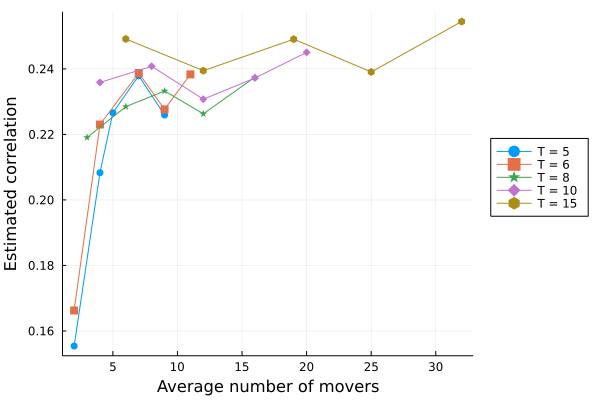

In [226]:
corr_mover_p = plot()
for (i, marker) in zip(1:length(time_val), [:circle, :rect, :star5, :diamond, :hexagon])
    t = time_val[i]
    plot!(output[:, 2, i], output[:, 1, i], 
        markershape = marker, 
        markerstrokewidth = 0,
        label = "T = $t",
        legend = :outerright)
end
xlabel!("Average number of movers")
ylabel!("Estimated correlation")
display(corr_mover_p)

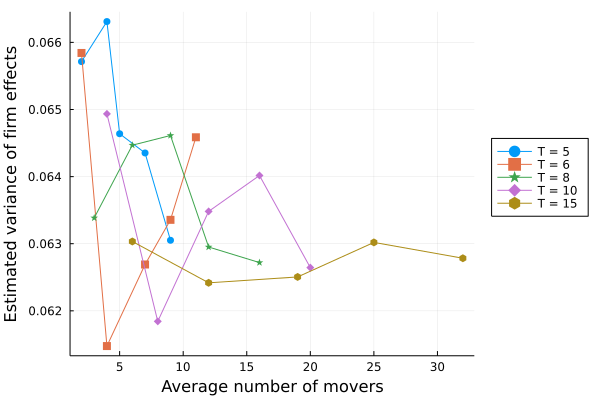

In [227]:
estimated_var_p = plot()
for (i, marker) in zip(1:length(time_val), [:circle, :rect, :star5, :diamond, :hexagon])
    t = time_val[i]
    plot!(output[:, 2, i], output[:, 4, i], 
        markershape = marker, 
        markerstrokewidth = 0,
        label = "T = $t",
        legend = :outerright)
end
xlabel!("Average number of movers")
ylabel!("Estimated variance of firm effects")
display(estimated_var_p)

## Correcting the bias

<span style="color:green">Question 9</span>

 - Implement both the exact as well as the approximated (Hutchkinson trace approximation) Andrews et al. type fixed-effect bias correction based on homoskedacity. Redo the plot from Question 6 so that it includes these 2 estimates.

In [228]:
function bias_estimation(df)

    NT = size(df)[1]
    nj = length(unique(df.j))

    # matrix for individual workers 
    A_α = sparse(zeros(NT, ni))
    for i in 1:NT
        A_α[i,df.i[i]] = 1
    end

    # matrix for workers and firms 
    A_ψ = sparse(zeros(NT, nj))
    for i in 1:NT
        A_ψ[i,df.j[i]] = 1
    end

    α_hat_init = 0.1
    ψ_hat_init = 0.1
    df = estimation(sim_df, α_hat_init, ψ_hat_init);
    var_eps = mean((df.lw - df.alpha_hat - df.psi_hat).^2)

    # using formula from Andrews et al. (2008)
    part1 = inv(Matrix(A_ψ'*A_ψ - A_ψ' * A_α*inv(Matrix(A_α'*A_α))*A_α' * A_ψ))
    part2 = A_ψ'*A_ψ - (A_ψ'*ones(NT,NT)*A_ψ) ./ NT
    part3 = part1 * part2
    bias_exact = var_eps .* tr(part3) ./ NT
    
    # draw Rademacher random vectors
    num_draw = 10
    trace_approx = zeros(num_draw,1)
    
    # using formula from Bonhomme et al. (2020)
    for i in 1:num_draw
        Rademacher = rand(nj,1)
        Rademacher = ifelse.(Rademacher .< 0.5, -1, 1)
        trace_approx[i] = (Rademacher' * part3 * Rademacher)[1]
    end
    bias_approx = var_eps .* mean(trace_approx) ./ NT
    
    return (bias_exact, bias_approx)
end

bias_estimation (generic function with 1 method)

In [229]:
# mob_vec = [0.02, 0.04, 0.06, 0.08, 0.1]

bias = zeros(size(mob_val)[1], 3)

# Dmse_tol = 1e-9
α_hat_init = 0.01
ψ_hat_init = 0.01

for j in 1:size(mob_val)[1]
    Random.seed!(global_seed)
    
    mob = mob_val[j]
    
    
    df_temp = sim_panel(param_sol; get_df = 1, K = 30, L = 10, mob = 0.1, T = 10, I = 10000)
    df_temp = estimation(df_temp, α_hat_init, ψ_hat_init)
        
    bias1, bias2 = bias_estimation(df_temp)
        
    bias[j,1] = avg_num_mover(df_temp)
    bias[j,2] = bias1
    bias[j,3] = bias2
end

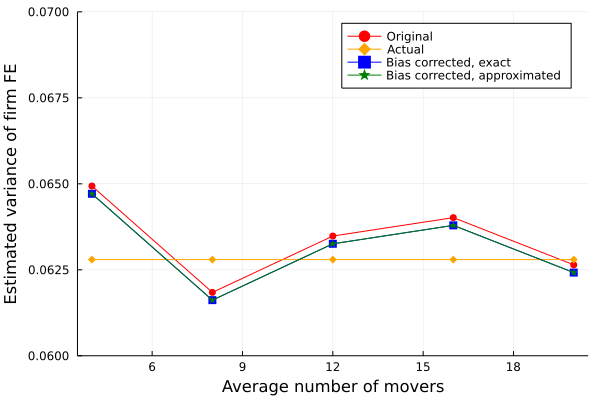

In [230]:
plot(output[:,2,4], output[:,4,4], 
    linecolor = :red, markershape = :circle, markercolor = :red, markerstrokewidth = 0, label = "Original")
plot!(output[:,2,4], output[:,3,4], 
    linecolor = :orange, markershape = :diamond, markercolor = :orange, markerstrokewidth = 0, label = "Actual")
plot!(output[:,2,4], output[:,4,4]-bias[:,2], 
    linecolor = :blue, markershape = :rect, markercolor = :blue, markerstrokewidth = 0, label = "Bias corrected, exact")
plot!(output[:,2,4], output[:,4,4]-bias[:,3], 
    linecolor = :green, markershape = :star5, markercolor = :green, markerstrokewidth = 0, label = "Bias corrected, approximated", legend = :topright, ylims = (0.06, 0.07))
xlabel!("Average number of movers")
ylabel!("Estimated variance of firm FE")

Comment: we expect the estimated variance of firm FE to be strictly decreasing in the average number of movers but it is not the case here. However, we do observe that the difference between the estimates the the actual value become smaller as the mean number of movers gets larger. Moreover, the exact and the approximated bias correction give nearly identical results. 

## Evidence of learning

<span style="color:green">Question 10</span>

 - Regress the wage of a worker at time $t$ on his wage at time $t-l$ and the average wage of his co-workers at time $t-l$ for some lags $l$ focusing on workers that did change firms between $t-l$ and $t$. 
 - Comment on the result.


In [231]:
sort!(sim_df,[:i, :t, :j])
l = 2

df_coworker_wage = @chain sim_df begin 
    # compute average wage of coworkers 
    @transform!(:worker_dum = 1)
    groupby([:j, :t])
    @transform!(:lw_total = sum(:lw), :N = sum(:worker_dum))
    @subset(:N .!= 1) # some of firms only have one worker so i have to drop those 
    @transform!(:lw_coworker = (:lw_total .- :lw)./(:N .- 1))
    
    # compute own and coworkers' wage lags
    groupby([:i])
    transform(:lw => (x -> lag(x, l)) => :lw_lag)
    groupby([:i])
    transform(:lw_coworker => (x -> lag(x, l)) => :lw_lag_coworker)
    
    # keep only workers who moved between t-l and t 
    groupby([:i])
    transform(:j => (x -> lag(x, l)) => :j_lag)
    @subset(:j .!= :j_lag)
end 

df_coworker_wage

# df_coworker_wage[!, [:i, :j, :t, :lw, :lw_coworker, :lw_lag, :lw_lag_coworker, :j_lag]]
describe(df_coworker_wage)

# # regress current wage on own wage at t-l and coworker's wage at t-l 
using GLM
reg = lm(@formula(lw ~ lw_lag + lw_lag_coworker), df_coworker_wage)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

lw ~ 1 + lw_lag + lw_lag_coworker

Coefficients:
───────────────────────────────────────────────────────────────────────────────────
                       Coef.  Std. Error       t  Pr(>|t|)   Lower 95%    Upper 95%
───────────────────────────────────────────────────────────────────────────────────
(Intercept)       0.00228912  0.00234619    0.98    0.3292  -0.0023097   0.00688794
lw_lag            1.00391     0.00611958  164.05    <1e-99   0.991918    1.01591
lw_lag_coworker  -0.607922    0.00900613  -67.50    <1e-99  -0.625575   -0.590268
───────────────────────────────────────────────────────────────────────────────────

The regression results suggest that worker's previous wage at t-2 increases current wage at new firm by 1.00 percentage points while co-worker's previous wage decreases current wage by 0.61 percentage points. We find this result surprising because we would expect that previous coworkers' wage has a positive impact on one's current wage. It could be a problem with the data generating process but we are not sure.  